<a href="https://colab.research.google.com/github/sujin-create/finedu/blob/main/%EA%B8%88%EC%9C%B5%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D/%EA%B8%88%EC%9C%B5_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D(%EC%98%A4%ED%94%84%EB%9D%BC%EC%9D%B8)_stock2vec_kospi200_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt # 차트를 그리기 위한 matplotlib을 임포트
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.


# 1. KOSPI 200에 대한 종목명과 종목 코드, 그리고 종가 얻기

In [1]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import FinanceDataReader as fdr
from bs4 import BeautifulSoup
import urllib.request as req
import requests
import numpy as np
from tqdm import tqdm

##1-1. 종목명과 종목 코드 얻기

https://finance.naver.com/sise/entryJongmok.nhn?&page=1

위의 링크를 들어가보시면 코스피 시가 총액 순으로 정렬되어져 있는 각 종목에 대한 정보가 나옵니다.  

* page의 숫자를 바꾸면 페이지 이동이 가능합니다. => 이를 이용해서 200개 종목을 대상으로 삼습니다.
* 종목명과 해당 종목에 대한 종목 코드를 어떻게 얻을지 고민해야 합니다.

1페이지의 10개 종목에 대해서 종목과 종목 코드를 뽑아봅시다.

In [3]:
url = 'https://finance.naver.com/sise/entryJongmok.nhn?&page=1'

* 변수 = requests.get('주소')  
* 변수명.content  

위 코드는 해당 주소의 HTML 코드를 불러옵니다.

In [4]:
r = requests.get(url)
r.content

b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">\n<html>\n<head>\n<meta http-equiv="Content-Type" content="text/html; charset=euc-kr">\n<title>\xb3\xd7\xc0\xcc\xb9\xf6 \xb1\xdd\xc0\xb6</title>\n\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20220719195125/css/newstock.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20220719195125/css/common.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20220719195125/css/layout.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20220719195125/css/main.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20220719195125/css/newstock2.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20220719195125/css/newstock3.css">\n<link rel="stylesheet" type="text/css" href="https://ss

이제 해당 주소로부터 각 종목과 종목 코드를 추출해야 할텐데  
이는 마우스 우클릭 > 검사 > Ctrl + F(검색 기능)을 적절히 사용하면 됩니다.

탐색 결과 HTML 코드에서 다음과 같은 형식에서 종목명과 종목코드를 뽑아올 수 있음을 알았습니다.

```
<td class="ctg">
 <a href="/item/main.nhn?code='종목코드' target="_parent">종목명</a>
</td>
```

BeautifulSoup를 이용하여 해당 주소로부터 태그 td에서 클래스값이 ctg인 경우만 파싱하여 리스트에 저장해봅시다.

In [5]:
soup = BeautifulSoup(r.content, "html.parser")
kospi_list = soup.select("td.ctg")

In [6]:
kospi_list

[<td class="ctg"><a href="/item/main.naver?code=005930" target="_parent">삼성전자</a></td>,
 <td class="ctg"><a href="/item/main.naver?code=373220" target="_parent">LG에너지솔루션</a></td>,
 <td class="ctg"><a href="/item/main.naver?code=000660" target="_parent">SK하이닉스</a></td>,
 <td class="ctg"><a href="/item/main.naver?code=207940" target="_parent">삼성바이오로직스</a></td>,
 <td class="ctg"><a href="/item/main.naver?code=035420" target="_parent">NAVER</a></td>,
 <td class="ctg"><a href="/item/main.naver?code=005380" target="_parent">현대차</a></td>,
 <td class="ctg"><a href="/item/main.naver?code=051910" target="_parent">LG화학</a></td>,
 <td class="ctg"><a href="/item/main.naver?code=006400" target="_parent">삼성SDI</a></td>,
 <td class="ctg"><a href="/item/main.naver?code=000270" target="_parent">기아</a></td>,
 <td class="ctg"><a href="/item/main.naver?code=035720" target="_parent">카카오</a></td>]

1페이지에서 해당 형식을 모두 잡아냈습니다.  
여기서 아래의 코드를 사용하면 href 값을 뽑아올 수 있습니다.

* 태그명.get('속성의 이름')

In [7]:
kospi_list[0]

<td class="ctg"><a href="/item/main.naver?code=005930" target="_parent">삼성전자</a></td>

In [8]:
kospi_list[0].a.get('href')

'/item/main.naver?code=005930'

위 코드로부터 005930을 추출하는 방법은 파이썬의 인덱스 슬라이싱을 사용하는 것입니다.  
뒤에서 6개의 값만 추출하고자 한다면 다음과 같이 코드를 수행하면 됩니다.

In [9]:
kospi_list[0].a.get('href')[-6:]

'005930'

지금까지 배운 것을 응용하여 1페이지부터 20페이지까지 수행합니다.  
각 페이지당 10개인데다가 시가총액 순으로 정렬되어져 있으므로  
20페이지를 수행하면 KOSPI 상위 200개의 종목명과 종목 코드를 뽑아올 수 있습니다.

##1-2. 20페이지에 대해서 수행하기

In [10]:
kospi200_dict = {}
kospi200_list = []
Url = "https://finance.naver.com/sise/entryJongmok.nhn?&page="

# 1페이지부터 20페이지까지에 대해서 아래의 반복문을 반복.
for i in tqdm(range(1,21)):
    url = Url + str(i)
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "html.parser")

    # td 태그의 클래스 값이 ctg인 경우를 전부 추출
    kospi_list = soup.select("td.ctg")
    for name in kospi_list:
        krx = name.a.get('href')[-6:]
        kospi200_dict[krx] = name.string.replace(" ", "")
        kospi200_list.append(krx)

100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


In [11]:
print('KOSPI 200 리스트의 길이는 : {}'.format(len(kospi200_list)))

KOSPI 200 리스트의 길이는 : 200


In [12]:
print(kospi200_list)

['005930', '373220', '000660', '207940', '035420', '005380', '051910', '006400', '000270', '035720', '068270', '028260', '012330', '005490', '105560', '055550', '096770', '034730', '066570', '323410', '015760', '259960', '003550', '032830', '011200', '034020', '017670', '051900', '033780', '329180', '086790', '009150', '018260', '010950', '302440', '030200', '000810', '003490', '003670', '316140', '010130', '377300', '036570', '090430', '011070', '024110', '352820', '086280', '009830', '326030', '251270', '097950', '361610', '009540', '402340', '011170', '034220', '018880', '383220', '035250', '032640', '011790', '047810', '010140', '021240', '137310', '000720', '004020', '000100', '005830', '267250', '161390', '006800', '271560', '180640', '000060', '028050', '128940', '011780', '078930', '004990', '029780', '071050', '010620', '020150', '036460', '138040', '003410', '002790', '282330', '139480', '005940', '016360', '241560', '008560', '028670', '001450', '008770', '010060', '008930',

In [13]:
print(kospi200_dict)

{'005930': '삼성전자', '373220': 'LG에너지솔루션', '000660': 'SK하이닉스', '207940': '삼성바이오로직스', '035420': 'NAVER', '005380': '현대차', '051910': 'LG화학', '006400': '삼성SDI', '000270': '기아', '035720': '카카오', '068270': '셀트리온', '028260': '삼성물산', '012330': '현대모비스', '005490': 'POSCO홀딩스', '105560': 'KB금융', '055550': '신한지주', '096770': 'SK이노베이션', '034730': 'SK', '066570': 'LG전자', '323410': '카카오뱅크', '015760': '한국전력', '259960': '크래프톤', '003550': 'LG', '032830': '삼성생명', '011200': 'HMM', '034020': '두산에너빌리티', '017670': 'SK텔레콤', '051900': 'LG생활건강', '033780': 'KT&G', '329180': '현대중공업', '086790': '하나금융지주', '009150': '삼성전기', '018260': '삼성에스디에스', '010950': 'S-Oil', '302440': 'SK바이오사이언스', '030200': 'KT', '000810': '삼성화재', '003490': '대한항공', '003670': '포스코케미칼', '316140': '우리금융지주', '010130': '고려아연', '377300': '카카오페이', '036570': '엔씨소프트', '090430': '아모레퍼시픽', '011070': 'LG이노텍', '024110': '기업은행', '352820': '하이브', '086280': '현대글로비스', '009830': '한화솔루션', '326030': 'SK바이오팜', '251270': '넷마블', '097950': 'CJ제일제당', '361610': 'SK아이이테크놀로지

In [14]:
len(kospi200_dict)

200

In [15]:
reverse_dict = {v: k for k, v in kospi200_dict.items()}

In [16]:
reverse_dict

{'BGF리테일': '282330',
 'BNK금융지주': '138930',
 'CJ': '001040',
 'CJ대한통운': '000120',
 'CJ제일제당': '097950',
 'DB손해보험': '005830',
 'DB하이텍': '000990',
 'DL': '000210',
 'DL이앤씨': '375500',
 'F&F': '383220',
 'GKL': '114090',
 'GS': '078930',
 'GS건설': '006360',
 'GS리테일': '007070',
 'HDC현대산업개발': '294870',
 'HD현대': '267250',
 'HMM': '011200',
 'KB금융': '105560',
 'KCC': '002380',
 'KG스틸': '016380',
 'KT': '030200',
 'KT&G': '033780',
 'LG': '003550',
 'LG디스플레이': '034220',
 'LG생활건강': '051900',
 'LG에너지솔루션': '373220',
 'LG유플러스': '032640',
 'LG이노텍': '011070',
 'LG전자': '066570',
 'LG화학': '051910',
 'LIG넥스원': '079550',
 'LS': '006260',
 'LSELECTRIC': '010120',
 'LX인터내셔널': '001120',
 'NAVER': '035420',
 'NH투자증권': '005940',
 'OCI': '010060',
 'PI첨단소재': '178920',
 'POSCO홀딩스': '005490',
 'S-Oil': '010950',
 'SK': '034730',
 'SKC': '011790',
 'SK네트웍스': '001740',
 'SK바이오사이언스': '302440',
 'SK바이오팜': '326030',
 'SK스퀘어': '402340',
 'SK아이이테크놀로지': '361610',
 'SK이노베이션': '096770',
 'SK케미칼': '285130',
 'SK텔레콤': '017670

In [17]:
import pandas as pd

In [18]:
result_df = pd.DataFrame(list(reverse_dict.items()),
                   columns=['company', 'code'])

In [19]:
result_df.to_csv('stock_df.csv', index=False)

#2. 수년 간의 각 종목의 변화율 값 얻기

## 2-1. 특정 종목의 가격 변화율 얻기

In [20]:
import pandas as pd

예를 들어 삼성전자의 2015년 1월부터 2021년 7월까지의 종가를 받아오는 방법은 다음과 같습니다.

In [21]:
samsung_df = fdr.DataReader('005930', '2015-01-01', '2021-07-22')['Close']

In [22]:
samsung_df

Date
2015-01-02    26600
2015-01-05    26660
2015-01-06    25900
2015-01-07    26140
2015-01-08    26280
              ...  
2021-07-16    79800
2021-07-19    79000
2021-07-20    79000
2021-07-21    78500
2021-07-22    79700
Name: Close, Length: 1614, dtype: int64

In [23]:
samsung_df.head()

Date
2015-01-02    26600
2015-01-05    26660
2015-01-06    25900
2015-01-07    26140
2015-01-08    26280
Name: Close, dtype: int64

종가의 변화율을 알고 싶다면 .pct_change()를 사용합니다.

In [24]:
samsung_df = samsung_df.pct_change()
samsung_df

Date
2015-01-02         NaN
2015-01-05    0.002256
2015-01-06   -0.028507
2015-01-07    0.009266
2015-01-08    0.005356
                ...   
2021-07-16   -0.009926
2021-07-19   -0.010025
2021-07-20    0.000000
2021-07-21   -0.006329
2021-07-22    0.015287
Name: Close, Length: 1614, dtype: float64

과거 데이터 대비 변화율이므로 맨 앞의 데이터는 과거 데이터가 없어서 결측값(Null)이 생깁니다.

결측값을 제거해줍니다.

In [25]:
samsung_df = samsung_df.dropna()
samsung_df

Date
2015-01-05    0.002256
2015-01-06   -0.028507
2015-01-07    0.009266
2015-01-08    0.005356
2015-01-09    0.000000
                ...   
2021-07-16   -0.009926
2021-07-19   -0.010025
2021-07-20    0.000000
2021-07-21   -0.006329
2021-07-22    0.015287
Name: Close, Length: 1613, dtype: float64

열이 1개인 데이터이므로 이 데이터는 데이터프레임이 아니라 '시리즈(Series)'입니다.

In [26]:
type(samsung_df)

pandas.core.series.Series

아래의 코드를 수행하면 열이 1개인 시리즈라도 강제로 데이터프레임 타입으로 변환이 가능합니다.  

* pd.Dataframe(시리즈)

In [27]:
samsung_df = pd.DataFrame(samsung_df)
samsung_df

,Close
Date,
2015-01-05,0.002256
2015-01-06,-0.028507
2015-01-07,0.009266
2015-01-08,0.005356
2015-01-09,0.000000
...,...
2021-07-16,-0.009926
2021-07-19,-0.010025
2021-07-20,0.000000


열 이름을 'rate'로 바꿔봅시다. 데이터프레임이름.columns를 사용하면 해당 데이터프레임의 열 값들이 나오는데 이 값을 수정해주면 됩니다.

In [28]:
samsung_df.columns

Index(['Close'], dtype='object')

In [29]:
samsung_df.columns.values[0] = 'rate'
samsung_df

,rate
Date,
2015-01-05,0.002256
2015-01-06,-0.028507
2015-01-07,0.009266
2015-01-08,0.005356
2015-01-09,0.000000
...,...
2021-07-16,-0.009926
2021-07-19,-0.010025
2021-07-20,0.000000


지금까지 수행한 것을 모든 종목에 대해서 수행하고 하나의 데이터프레임으로 만들어줄 예정입니다.

## 2-2. 모든 종목에 대해서 수행하기

In [30]:
# 파이낸셜 데이터리더로부터 코스피 200 종목의 각 날짜별 변화율 받아와서 하나의 데이터프레임으로 전부 뒤로 append합니다.

In [31]:
def total_record(cprc):
    return (stock_code, cprc)

In [32]:
# tqdm을 원소를 꺼내올 파이썬의 리스트에 tqdm(리스트)로 감싸주시면 얼마나 진행되는지 프로그레스 바를 출력합니다.
data = None
index = 0

for stock_code in tqdm(kospi200_list):
    temp_df = fdr.DataReader(stock_code, '2015-01-01', '2021-07-22')['Close']

    # 만약 종목의 데이터가 없을 경우 확인을 위해서 출력
    if len(temp_df) == 0:
        print(stock_code,'는 데이터가 없습니다.')

    temp_df = temp_df.pct_change()
    temp_df = temp_df.dropna()
    temp_df = pd.DataFrame(temp_df)
    temp_df.columns.values[0] = 'rate'
    temp_df['rate'] = temp_df['rate'].map(lambda x : [total_record(x)])

    if index==0:
        # 맨 처음에는 데이터프레임이 존재하지 않으므로 데이터프레임을 하나 만듭니다.
        data=pd.DataFrame(temp_df.copy())
        index=index+1
    else:
        # 두번째 데이터프레임부터는 기존 데이터프레임에 데이터프레임을 뒤에 계속 추가합니다.
        data=data.append(temp_df)
        index=index+1

  1%|          | 2/200 [00:02<03:34,  1.08s/it]

373220 는 데이터가 없습니다.


 10%|█         | 20/200 [00:28<03:49,  1.27s/it]

323410 는 데이터가 없습니다.


 11%|█         | 22/200 [00:30<03:36,  1.22s/it]

259960 는 데이터가 없습니다.


 15%|█▌        | 30/200 [00:42<03:39,  1.29s/it]

329180 는 데이터가 없습니다.


 21%|██        | 42/200 [00:58<03:15,  1.24s/it]

377300 는 데이터가 없습니다.


 28%|██▊       | 55/200 [01:14<02:43,  1.13s/it]

402340 는 데이터가 없습니다.


 80%|████████  | 160/200 [03:43<00:51,  1.28s/it]

271940 는 데이터가 없습니다.


 88%|████████▊ | 177/200 [04:07<00:28,  1.23s/it]

381970 는 데이터가 없습니다.


100%|██████████| 200/200 [04:40<00:00,  1.40s/it]


In [33]:
len(data)

283953

In [34]:
# 계속 붙여나가서 데이터프레임의 크기가 30만이 되었습니다. 단순하게 생각했을 때는 200 종목 곱하기 5년치 절반 데이터 정도의 크기를 넘어야 하는데
# 주말 등을 빼서 30만밖에 안 되는 것 같습니다. 상위 5개만 출력해보겠습니다.

상위 5개의 행은 2015년 1월 5일부터 2015년 1월 9일까지의 (삼성전자, 전날 대비 변화율)이네요.

In [35]:
data.head()

,rate
Date,
2015-01-05,"[(005930, 0.0022556390977443996)]"
2015-01-06,"[(005930, -0.028507126781695424)]"
2015-01-07,"[(005930, 0.009266409266409203)]"
2015-01-08,"[(005930, 0.00535577658760511)]"
2015-01-09,"[(005930, 0.0)]"


2021년 7월 22일 데이터만 출력해봅시다.

In [36]:
Filter_df  = data[data.index.isin(['2021-07-22'])]

In [37]:
Filter_df

,rate
Date,
2021-07-22,"[(005930, 0.015286624203821653)]"
2021-07-22,"[(000660, 0.02136752136752129)]"
2021-07-22,"[(207940, -0.018867882150136683)]"
2021-07-22,"[(035420, 0.028037383177569986)]"
2021-07-22,"[(005380, 0.002192982456140413)]"
...,...
2021-07-22,"[(103140, 0.03604806408544725)]"
2021-07-22,"[(284740, -0.015401540154015403)]"
2021-07-22,"[(105630, 0.007009345794392496)]"


2021년 7월 22일에 대해서 200개의 종목이 전날 대비 변화율이 저장되어져 있습니다.

이제 전체 데이터프레임에서 동일한 날짜의 데이터는 전부 하나의 행으로 묶어주는 작업을 합니다.  
여기서 원하는 것은 각 날짜의 행에 (종목, 그 종목의 전날 비교 변화율)을 모아놓는 것입니다.

In [38]:
train_data=data.groupby(['Date']).sum()
train_data=pd.DataFrame(train_data)
train_data.columns.values[0] = 'rate'
train_data[:5]

,rate
Date,
2015-01-05,"[(005930, 0.0022556390977443996), (000660, -0...."
2015-01-06,"[(005930, -0.028507126781695424), (000660, -0...."
2015-01-07,"[(005930, 0.009266409266409203), (000660, -0.0..."
2015-01-08,"[(005930, 0.00535577658760511), (000660, 0.053..."
2015-01-09,"[(005930, 0.0), (000660, -0.005005005005005003..."


2015년 1월 5일의 데이터를 보겠습니다.

In [39]:
train_data['rate'][0]

[('005930', 0.0022556390977443996),
 ('000660', -0.0020942408376963817),
 ('035420', 0.02462313960398066),
 ('005380', -0.00591715976331364),
 ('051910', -0.030555555555555558),
 ('006400', -0.017094017094017144),
 ('000270', -0.005736137667303964),
 ('035720', 0.05319921562931218),
 ('068270', -0.005131181087932535),
 ('028260', -0.14912280701754388),
 ('012330', -0.006263048016701411),
 ('005490', -0.015873015873015928),
 ('105560', -0.01666666666666672),
 ('055550', -0.006741573033707815),
 ('096770', -0.023809523809523836),
 ('034730', 0.006507592190889477),
 ('066570', -0.006802721088435382),
 ('015760', -0.016393442622950838),
 ('003550', 0.008071825566481339),
 ('032830', 0.017391304347825987),
 ('011200', 0.0),
 ('034020', 0.011089404734543784),
 ('017670', 0.014675855028075446),
 ('051900', -0.012944983818770184),
 ('033780', 0.010230179028132946),
 ('086790', -0.020312499999999956),
 ('009150', 0.057657657657657735),
 ('018260', -0.02515723270440251),
 ('010950', -0.007201646

변화율 순으로 정렬합니다.

In [40]:
train_data['rate'] = train_data['rate'].map(lambda x : sorted(x, key=lambda x: x[1], reverse=True))

In [41]:
train_data['rate'][:5]

Date
2015-01-05    [(016380, 0.0860197263760738), (039130, 0.0802...
2015-01-06    [(009240, 0.05327868852459017), (081660, 0.038...
2015-01-07    [(005300, 0.07186903287181834), (008770, 0.057...
2015-01-08    [(000670, 0.06260296540362442), (051600, 0.058...
2015-01-09    [(039490, 0.1497382198952879), (028260, 0.1111...
Name: rate, dtype: object

In [42]:
print('훈련 데이터의 길이는 : {}'.format(len(train_data)))

훈련 데이터의 길이는 : 1613


정렬이 된 상황에서는 이제 변화율값이 필요가 없습니다. 종목 코드만 남깁니다.

In [43]:
train_data['rate'] = train_data['rate'].map(lambda x : [i[0] for i in x])

In [44]:
train_data['rate'][:5]

Date
2015-01-05    [016380, 039130, 036570, 010780, 009150, 03572...
2015-01-06    [009240, 081660, 034220, 051600, 066570, 00341...
2015-01-07    [005300, 008770, 011210, 005380, 015760, 01178...
2015-01-08    [000670, 051600, 009150, 011070, 017800, 01468...
2015-01-09    [039490, 028260, 006650, 009240, 012450, 07105...
Name: rate, dtype: object

훈련 데이터를 리스트 형태로 바꿔줍니다.

In [45]:
train_list = train_data.values.tolist()

In [46]:
len(train_list)

1613

In [47]:
print(train_list[0])

[['016380', '039130', '036570', '010780', '009150', '035720', '112610', '001230', '097950', '032640', '007310', '093370', '081660', '069620', '009240', '001680', '005850', '006650', '035420', '003490', '011070', '008770', '018880', '000080', '028670', '017800', '020560', '010620', '032830', '008930', '120110', '017670', '012750', '114090', '001040', '014680', '105630', '180640', '034020', '004020', '161890', '033780', '003670', '001800', '030200', '036460', '003550', '185750', '011790', '111770', '034730', '003240', '000150', '034220', '009830', '007070', '001450', '000720', '024110', '000810', '006040', '008560', '005930', '011200', '047810', '138040', '001440', '011210', '010120', '001740', '032350', '003850', '051600', '004800', '005300', '000660', '204320', '042670', '014820', '000880', '011780', '068270', '005440', '047040', '000270', '000100', '005380', '103140', '012330', '009420', '035250', '055550', '066570', '001120', '052690', '021240', '010950', '006280', '004990', '002790'

현재 리스트가 삼중 리스트이므로 이중 리스트로 바꿔줍니다.

In [48]:
train_list = [item[0] for item in train_list]

In [49]:
len(train_list)

1613

In [50]:
print(train_list[0])

['016380', '039130', '036570', '010780', '009150', '035720', '112610', '001230', '097950', '032640', '007310', '093370', '081660', '069620', '009240', '001680', '005850', '006650', '035420', '003490', '011070', '008770', '018880', '000080', '028670', '017800', '020560', '010620', '032830', '008930', '120110', '017670', '012750', '114090', '001040', '014680', '105630', '180640', '034020', '004020', '161890', '033780', '003670', '001800', '030200', '036460', '003550', '185750', '011790', '111770', '034730', '003240', '000150', '034220', '009830', '007070', '001450', '000720', '024110', '000810', '006040', '008560', '005930', '011200', '047810', '138040', '001440', '011210', '010120', '001740', '032350', '003850', '051600', '004800', '005300', '000660', '204320', '042670', '014820', '000880', '011780', '068270', '005440', '047040', '000270', '000100', '005380', '103140', '012330', '009420', '035250', '055550', '066570', '001120', '052690', '021240', '010950', '006280', '004990', '002790',

코드로 보는 것보단 종목 이름으로 보는 게 더 편하겠죠. 이중 리스트에 있는 종목 코드들을 전부 이름으로 바꿔줍니다.  
이는 앞서 만들어놓은 kospi200_dict를 사용하면 됩니다.

In [51]:
kospi200_dict['014820']

'동원시스템즈'

In [52]:
kospi200_dict['010130']

'고려아연'

In [53]:
print(len(kospi200_dict))

200


In [54]:
temp2=[]
for line in tqdm(train_list):
  temp1=[]
  for code in line:
    temp1.append(kospi200_dict[code])
  temp2.append(temp1)

100%|██████████| 1613/1613 [00:00<00:00, 19128.25it/s]


In [55]:
len(temp2)

1613

In [56]:
print(temp2[0])

['KG스틸', '하나투어', '엔씨소프트', '아이에스동서', '삼성전기', '카카오', '씨에스윈드', '동국제강', 'CJ제일제당', 'LG유플러스', '오뚜기', '후성', '휠라홀딩스', '대웅제약', '한샘', '대상', '에스엘', '대한유화', 'NAVER', '대한항공', 'LG이노텍', '호텔신라', '한온시스템', '하이트진로', '팬오션', '현대엘리베이', '아시아나항공', '현대미포조선', '삼성생명', '한미사이언스', '코오롱인더', 'SK텔레콤', '에스원', 'GKL', 'CJ', '한솔케미칼', '한세실업', '한진칼', '두산에너빌리티', '현대제철', '한국콜마', 'KT&G', '포스코케미칼', '오리온홀딩스', 'KT', '한국가스공사', 'LG', '종근당', 'SKC', '영원무역', 'SK', '태광산업', '두산', 'LG디스플레이', '한화솔루션', 'GS리테일', '현대해상', '현대건설', '기업은행', '삼성화재', '동원산업', '메리츠증권', '삼성전자', 'HMM', '한국항공우주', '메리츠금융지주', '대한전선', '현대위아', 'LSELECTRIC', 'SK네트웍스', '롯데관광개발', '보령', '한전KPS', '효성', '롯데칠성', 'SK하이닉스', '만도', '현대두산인프라코어', '동원시스템즈', '한화', '금호석유', '셀트리온', '현대그린푸드', '대우건설', '기아', '유한양행', '현대차', '풍산', '현대모비스', '한올바이오파마', '강원랜드', '신한지주', 'LG전자', 'LX인터내셔널', '한전기술', '코웨이', 'S-Oil', '녹십자', '롯데지주', '아모레G', '녹십자홀딩스', '아모레퍼시픽', '한섬', '현대글로비스', '삼양홀딩스', '한국금융지주', '코스맥스', 'LG생활건강', 'LS', '신세계인터내셔날', '포스코인터내셔널', '동서', '신세계', '일진머티리얼즈', 'BNK금융지주', 'DB하이텍', '한국앤컴퍼니', '이마트', '현

In [57]:
# 생성된 데이터에 대해서 Word2Vec을 돌려봅니다.

In [59]:
from gensim.models import Word2Vec # 이 데이터에 대해서 워드 임베딩을 해봅시다.
from gensim.models import KeyedVectors

In [60]:
sg_model = Word2Vec(sentences=temp2, size=100, window=3, min_count=5, workers=4, sg=1)

In [61]:
case1=sg_model.wv.most_similar("현대차")
print(case1)

[('LG', 0.8563272953033447), ('현대글로비스', 0.8528943061828613), ('KT&G', 0.8447861671447754), ('고려아연', 0.8401343822479248), ('한국전력', 0.8375749588012695), ('SK텔레콤', 0.8364244699478149), ('에스원', 0.8235296010971069), ('삼성생명', 0.8225979804992676), ('대한항공', 0.8179834485054016), ('LSELECTRIC', 0.8158900141716003)]


In [62]:
sg_model.wv.save_word2vec_format('stock2vec_skipgram') # 모델 저장

In [63]:
model = KeyedVectors.load_word2vec_format("stock2vec_skipgram") # 모델 로드

In [64]:
case1=model.wv.most_similar("현대차")
print(case1)

[('LG', 0.8563272953033447), ('현대글로비스', 0.8528943061828613), ('KT&G', 0.8447861671447754), ('고려아연', 0.8401343822479248), ('한국전력', 0.8375749588012695), ('SK텔레콤', 0.8364244699478149), ('에스원', 0.8235296010971069), ('삼성생명', 0.8225979804992676), ('대한항공', 0.8179834485054016), ('LSELECTRIC', 0.8158900141716003)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [65]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic') 
# plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (14,4)

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54008 missing from current font.
  font.set_text(s, 0.0,

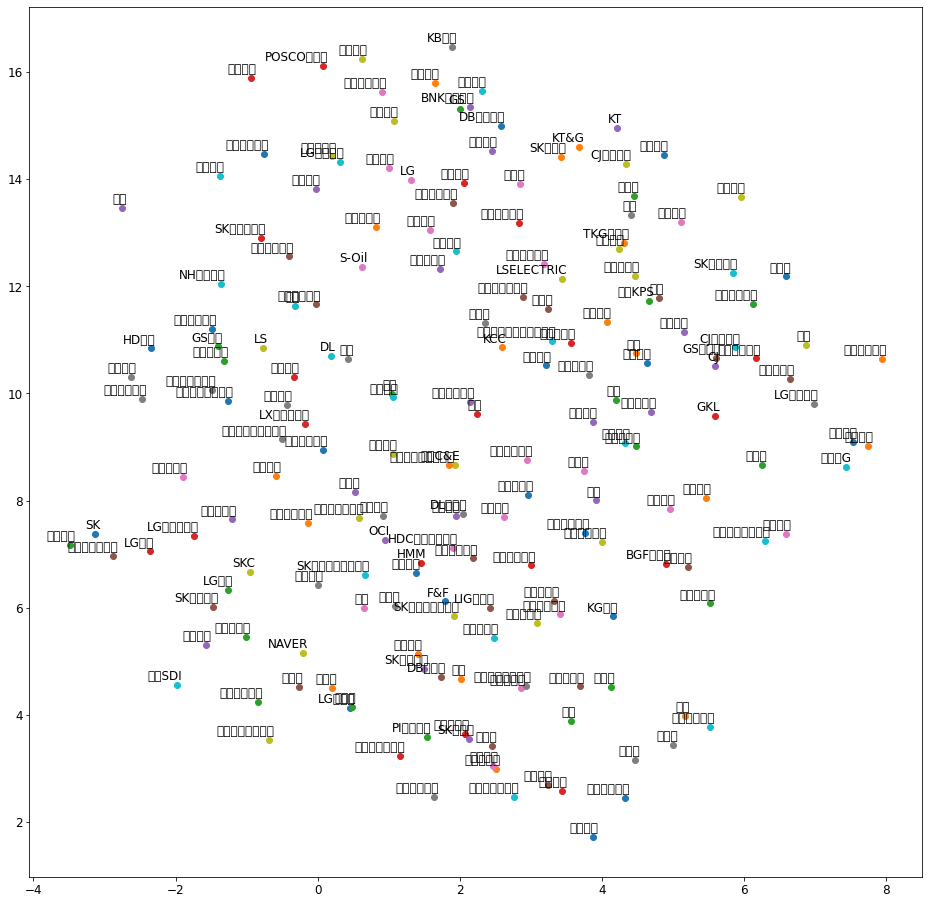

In [66]:
tsne_plot(model)

금융 지주회사들이 군집되고, 종근당이나 녹집자홀딩스, 녹십자 등과 같은 업체들, 그리고 일부 조선과 건설업 회사들이 군집되는 것을 확인했습니다.

In [67]:
from sklearn.cluster import KMeans

word_vectors = model.wv.syn0
num_clusters = 5

print(num_clusters)

5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
len(word_vectors)

191

In [69]:
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

In [70]:
skipgram_dict = {}

In [71]:
idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

# 첫 번째 클러스터의 처음 20개를 출력
for cluster in range(0, num_clusters):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))

    # 클러스터 번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
            skipgram_dict[list(word_centroid_map.keys())[i]]=cluster
    print(words)


Cluster 0
['하나투어', '아이에스동서', '오뚜기', '휠라홀딩스', '한샘', '대상', '에스엘', '호텔신라', '하이트진로', '아시아나항공', 'GKL', 'CJ', '한세실업', '한국콜마', '오리온홀딩스', '영원무역', 'GS리테일', '동원산업', 'SK네트웍스', '롯데관광개발', '한전KPS', '롯데칠성', '동원시스템즈', '현대그린푸드', '유한양행', '아모레G', '아모레퍼시픽', '한섬', '삼양홀딩스', '코스맥스', 'LG생활건강', '신세계인터내셔날', '동서', '신세계', '현대홈쇼핑', '현대백화점', '제일기획', '롯데쇼핑', '금호타이어', '농심', 'CJ대한통운', 'BGF리테일']

Cluster 1
['엔씨소프트', '삼성전기', '카카오', 'NAVER', 'LG이노텍', '한온시스템', '한진칼', '포스코케미칼', 'SKC', 'LG디스플레이', '현대위아', 'SK하이닉스', '만도', '현대모비스', 'LG전자', '삼성SDI', 'SK이노베이션', '삼성에스디에스', 'LG화학', '삼성바이오로직스', '넷마블', '오리온', 'SK아이이테크놀로지']

Cluster 2
['동국제강', '대한유화', '팬오션', '현대미포조선', '코오롱인더', '두산에너빌리티', '현대제철', '두산', '한화솔루션', '현대건설', 'HMM', '한국항공우주', '대한전선', '효성', '현대두산인프라코어', '한화', '금호석유', '대우건설', '풍산', 'LX인터내셔널', '한전기술', 'S-Oil', '한국금융지주', 'LS', '포스코인터내셔널', '이마트', 'NH투자증권', 'KCC', 'POSCO홀딩스', '키움증권', '롯데정밀화학', '쌍용C&E', '현대로템', '대우조선해양', '삼성중공업', 'OCI', '미래에셋증권', '롯데케미칼', '삼성엔지니어링', 'DL', '한국조선해양', '한화에어로스페이스', 'GS건설', '두산밥캣', 'HD현대', 'DL이앤씨']

Cl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [72]:
num_clusters = 7

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

# 첫 번째 클러스터의 처음 20개를 출력
for cluster in range(0, num_clusters):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))

    # 클러스터 번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
            skipgram_dict[list(word_centroid_map.keys())[i]]=cluster
    print(words)


Cluster 0
['하나투어', '호텔신라', '한세실업', '한국콜마', '아모레G', '아모레퍼시픽', '코스맥스', 'LG생활건강', '신세계인터내셔날', '신세계']

Cluster 1
['KG스틸', '아이에스동서', '한샘', '에스엘', '대한유화', '팬오션', '현대엘리베이', '아시아나항공', '코오롱인더', '한솔케미칼', '한진칼', 'HMM', '한국항공우주', '대한전선', '롯데관광개발', '효성', '만도', '동원시스템즈', '금호석유', '한전기술', '롯데정밀화학', '쌍용C&E', 'OCI', '한화에어로스페이스', 'LIG넥스원', '더블유게임즈', 'HDC현대산업개발', '효성티앤씨', '한일시멘트', 'DL이앤씨', 'SK바이오사이언스', 'F&F']

Cluster 2
['CJ제일제당', '대한항공', '삼성생명', 'SK텔레콤', 'KT&G', 'KT', '한국가스공사', 'LG', 'SK', '현대해상', '기업은행', '삼성화재', '메리츠증권', '삼성전자', '기아', '현대차', '강원랜드', '신한지주', '현대글로비스', '한국금융지주', 'BNK금융지주', 'DB손해보험', 'POSCO홀딩스', '메리츠화재', '한국전력', 'KB금융', 'GS', '삼성증권', '고려아연', '하나금융지주', '한화생명', '삼성카드', '우리금융지주']

Cluster 3
['씨에스윈드', '후성', '대웅제약', '한미사이언스', '종근당', '보령', '셀트리온', '한올바이오파마', '녹십자', '녹십자홀딩스', '일진머티리얼즈', 'DB하이텍', 'PI첨단소재', '신풍제약', '한미약품', '대웅', '화승엔터프라이즈', '오리온', 'SK케미칼', '쿠쿠홈시스', '효성첨단소재', '두산퓨얼셀', '지누스', '한화시스템', 'SK바이오팜', '하이브', '명신산업']

Cluster 4
['오뚜기', '휠라홀딩스', '대상', '하이트진로', '에스원', 'GKL', 'CJ', '오리온홀딩스', '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [73]:
from gensim.models import Word2Vec # 이 데이터에 대해서 워드 임베딩을 해봅시다.
from gensim.models import KeyedVectors

In [74]:
cb_model = Word2Vec(sentences=temp2, size=100, window=3, min_count=5, workers=4, sg=0)

In [75]:
case1=cb_model.wv.most_similar("현대차")
print(case1)

[('GS', 0.9954241514205933), ('BNK금융지주', 0.9949771165847778), ('현대해상', 0.9943504333496094), ('삼성카드', 0.9941971302032471), ('한화생명', 0.9941631555557251), ('우리금융지주', 0.9939818382263184), ('SK텔레콤', 0.9936828017234802), ('삼성전자', 0.9934712648391724), ('DB손해보험', 0.9934020042419434), ('고려아연', 0.9933938980102539)]


In [76]:
case2=cb_model.wv.most_similar("삼성증권")
print(case2)

[('GS', 0.9962698221206665), ('우리금융지주', 0.9961384534835815), ('BNK금융지주', 0.9942545890808105), ('삼성카드', 0.9941821694374084), ('NH투자증권', 0.9939167499542236), ('POSCO홀딩스', 0.9938011169433594), ('현대차', 0.9933653473854065), ('현대해상', 0.9930404424667358), ('현대제철', 0.9910240769386292), ('SK텔레콤', 0.9904414415359497)]


In [77]:
case3=cb_model.wv.most_similar("롯데케미칼")
print(case3)

[('LS', 0.9934096932411194), ('대우건설', 0.9925656914710999), ('삼성중공업', 0.991037130355835), ('DL', 0.9899377822875977), ('HD현대', 0.9896251559257507), ('SK이노베이션', 0.9883832335472107), ('KCC', 0.9877938032150269), ('한화', 0.9877265691757202), ('삼성에스디에스', 0.9875689744949341), ('현대미포조선', 0.9873998165130615)]


In [78]:
case4=cb_model.wv.most_similar("GS건설")
print(case4)

[('DL', 0.9951415657997131), ('현대건설', 0.9941787719726562), ('포스코인터내셔널', 0.993654727935791), ('삼성중공업', 0.9934556484222412), ('두산에너빌리티', 0.9934044480323792), ('대우건설', 0.9932907819747925), ('현대미포조선', 0.9931684732437134), ('두산밥캣', 0.9924591183662415), ('동국제강', 0.991969108581543), ('풍산', 0.9918709397315979)]


In [79]:
cb_model.wv.save_word2vec_format('stock2vec_cbow') # 모델 저장

In [80]:
model = KeyedVectors.load_word2vec_format("stock2vec_cbow") # 모델 로드

In [81]:
case1=model.wv.most_similar("현대차")
print(case1)

[('GS', 0.9954241514205933), ('BNK금융지주', 0.9949771165847778), ('현대해상', 0.9943504333496094), ('삼성카드', 0.9941971302032471), ('한화생명', 0.9941631555557251), ('우리금융지주', 0.9939818382263184), ('SK텔레콤', 0.9936828017234802), ('삼성전자', 0.9934712648391724), ('DB손해보험', 0.9934020042419434), ('고려아연', 0.9933938980102539)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


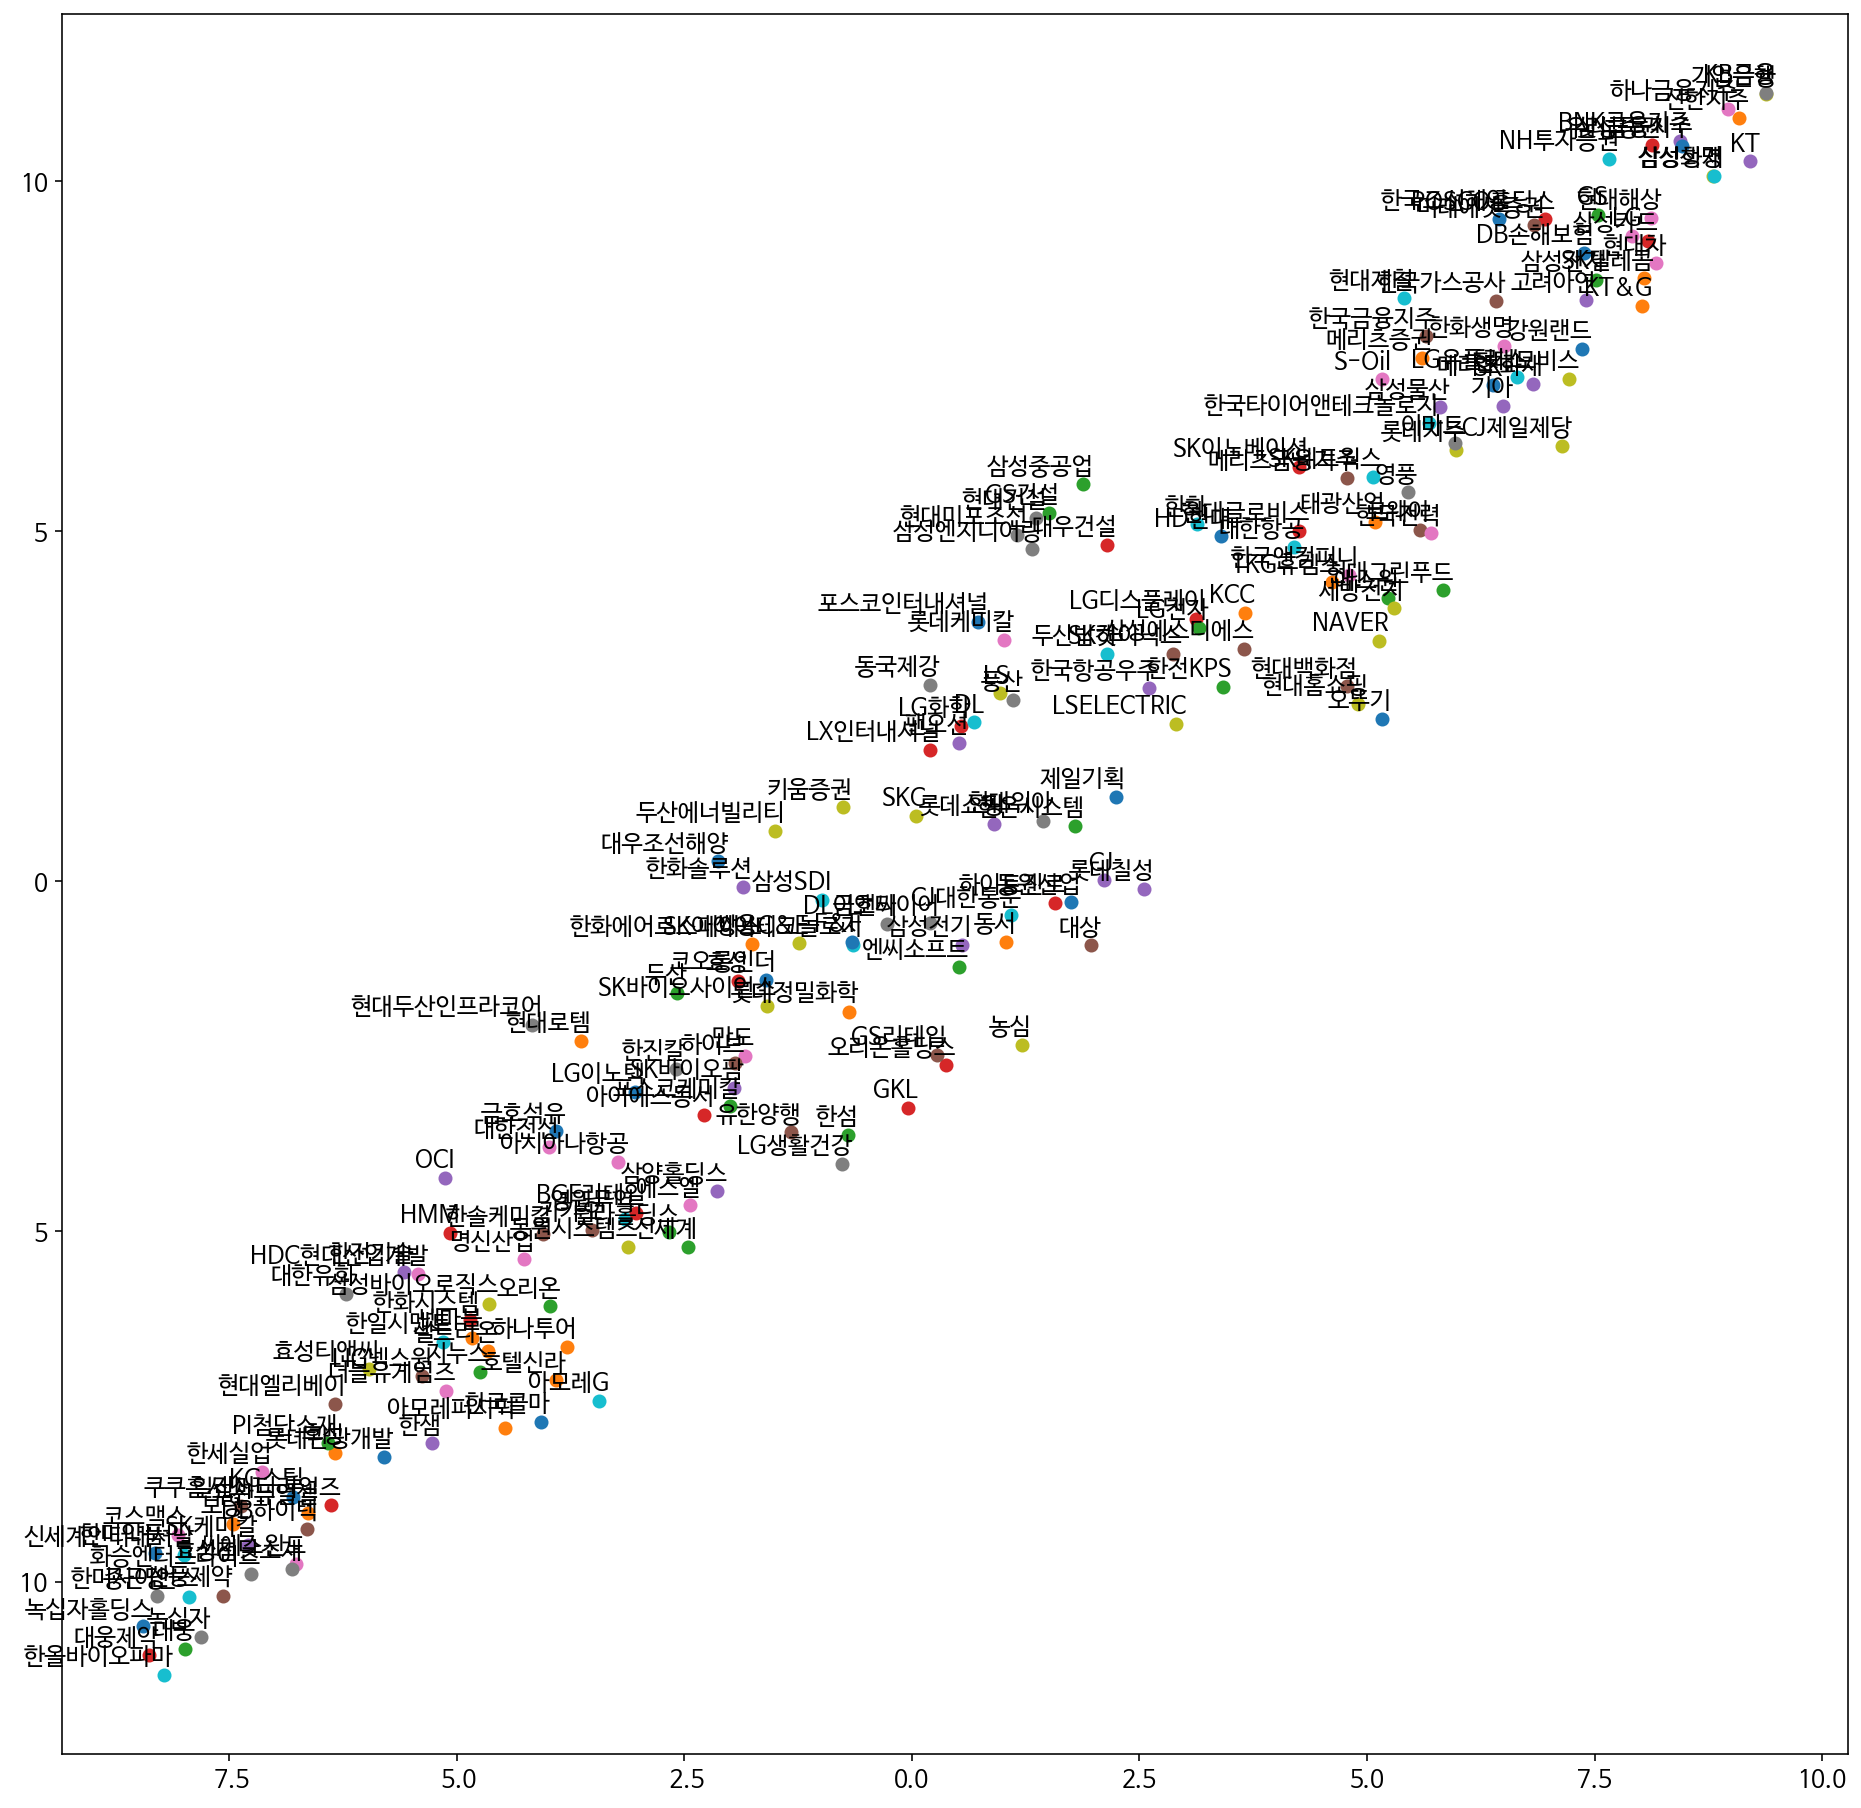

In [ ]:
tsne_plot(model)

In [82]:
from sklearn.cluster import KMeans

word_vectors = model.wv.syn0
num_clusters = 5

print(num_clusters)

5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

In [84]:
cbow_dict = {}

In [85]:
idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

# 첫 번째 클러스터의 처음 20개를 출력
for cluster in range(0, num_clusters):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))

    # 클러스터 번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
            cbow_dict[list(word_centroid_map.keys())[i]]=cluster
    print(words)
    


Cluster 0
['하나투어', '카카오', '씨에스윈드', '휠라홀딩스', '한샘', '에스엘', '대한유화', 'LG이노텍', '호텔신라', '현대엘리베이', '아시아나항공', '한솔케미칼', '한세실업', '포스코케미칼', '영원무역', 'HMM', '대한전선', '현대두산인프라코어', '동원시스템즈', '유한양행', '한전기술', '아모레G', '아모레퍼시픽', '삼양홀딩스', '신세계', 'DB하이텍', '현대로템', 'OCI', 'LIG넥스원', '더블유게임즈', '삼성바이오로직스', '넷마블', '오리온', 'HDC현대산업개발', '효성티앤씨', '한일시멘트', '지누스', '한화시스템', '하이브', '명신산업']

Cluster 1
['삼성생명', 'SK텔레콤', '현대제철', 'KT', '현대해상', '기업은행', '삼성화재', '삼성전자', '현대차', '신한지주', 'BNK금융지주', 'NH투자증권', 'DB손해보험', 'POSCO홀딩스', 'KB금융', 'GS', '삼성증권', '고려아연', '하나금융지주', '한화생명', '삼성카드', '우리금융지주']

Cluster 2
['KG스틸', '후성', '대웅제약', '한미사이언스', '한국콜마', '종근당', '롯데관광개발', '보령', '셀트리온', '한올바이오파마', '녹십자', '녹십자홀딩스', '코스맥스', '신세계인터내셔날', '일진머티리얼즈', 'PI첨단소재', '신풍제약', '한미약품', '대웅', '화승엔터프라이즈', 'SK케미칼', '쿠쿠홈시스', '효성첨단소재', '두산퓨얼셀']

Cluster 3
['엔씨소프트', '아이에스동서', '삼성전기', '동국제강', '오뚜기', '대상', 'NAVER', '대한항공', '한온시스템', '팬오션', '코오롱인더', 'GKL', 'CJ', '한진칼', '두산에너빌리티', '오리온홀딩스', 'SKC', '두산', 'LG디스플레이', '한화솔루션', 'GS리테일', '현대건설', '동원산업', '한국항공우주', '현대위아', '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
